In [1]:
import xarray as xr
import numpy  as np
# import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import proplot as plot

从mask后的数据计算每月的情况，将13年的4-8月绘制热图比较<br>

此处简单地做了个减法

remains:绘制更多统计量的

为了方便不更换变量名，用计算后的变量rmsd复制到此前的vr_mean上<br>
对于RMSD的计算还存疑，是先进行了直接做差之后的平方，之后在平均之后开根，类似于每个空间pattern做了一个RMSD，在每个时间维度上，这里需不需要提前对空间pattern做月平均？

0328
    
- 修改为先进行月平均图的计算之后再进行空间pattern的RMSD等诸多统计量的计算

08.18

-   修改到更大范围上进行了绘制

In [2]:
# 确定绘制的种类

partial_list = ["NE", "NC", "NWC", "YZ", "SC","SW"]
seasons_list = ['am', 'jja']
bias_dict = {}
rmsd_dict = {}
corr_dict = {}

bias_table = {}
rmsd_table = {}
corr_table = {}

for season in seasons_list:
    
    bias_region_dict = {}
    rmsd_region_dict = {}
    corr_region_dict = {}
    
    bias_region_table = {}
    rmsd_region_table = {}
    corr_region_table = {}

    for region in partial_list:

        # 读取数据
        main_path = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA_large/partial_pre/"+region+"/interannual/"

        dir_vr = main_path + season +"_vr_pre_98-17.nc"
        ds_vr = xr.open_dataset(dir_vr)
        # ds_vr

        # dir_rcm = "/raid52/yycheng/MPAS/RCM_postprocess/RCM_merge/pre/" + "daily_pre_03-15.nc"
        dir_rcm = main_path + season + "_rcm_pre_98-17.nc"
        ds_rcm = xr.open_dataset(dir_rcm)
        # ds_rcm

        obs_cn051 = main_path + season + "_obsmerge_pre_98-17.nc"
        ds_cn051 = xr.open_dataset(obs_cn051)

        # 整理数据

        obs_years  = ds_cn051['premerge']
        vr_years   = ds_vr['precip_MPAS']
        rcm_years  = ds_rcm['precip_MPAS']

        # rename coordinate name,和模式中的latitude longitude一样的经纬度坐标名
        rename_coords = dict(zip(obs_years.dims, vr_years.dims))
        obs_years     = obs_years.rename(rename_coords)

        # 计算RMSD，先取平方再开根
        vr_rmsd_temp  = (vr_years.values - obs_years.values)**2
        rcm_rmsd_temp = (rcm_years.values - obs_years.values)**2

        vr_rmsd_xr  = xr.DataArray(vr_rmsd_temp, coords = vr_years.coords)
        rcm_rmsd_xr = xr.DataArray(rcm_rmsd_temp, coords = rcm_years.coords)

        vr_rmsd  = np.sqrt(vr_rmsd_xr.mean(dim=["longitude","latitude"]))
        rcm_rmsd = np.sqrt(rcm_rmsd_xr.mean(dim=["longitude","latitude"]))

        # 计算BIAS
        vr_bias  =  vr_years.mean(dim=["longitude","latitude"]) - obs_years.mean(dim=["longitude","latitude"])
        rcm_bias = rcm_years.mean(dim=["longitude","latitude"]) - obs_years.mean(dim=["longitude","latitude"])

        # 计算空间pattern的corr
        vr_corr  = xr.corr(obs_years,  vr_years, dim=['latitude','longitude']).dropna(dim='Time')
        rcm_corr = xr.corr(obs_years, rcm_years, dim=['latitude','longitude']).dropna(dim='Time')

        # 合并到dict
        bias_region_dict[region] = {"vr":vr_bias, "rcm":rcm_bias} 
        rmsd_region_dict[region] = {"vr":vr_rmsd, "rcm":rcm_rmsd} 
        corr_region_dict[region] = {"vr":vr_corr, "rcm":rcm_corr}

        bias_region_table[region] = {"vr":vr_bias.mean().values, "rcm":rcm_bias.mean().values} 
        rmsd_region_table[region] = {"vr":vr_rmsd.mean().values, "rcm":rcm_rmsd.mean().values} 
        corr_region_table[region] = {"vr":vr_corr.mean().values, "rcm":rcm_corr.mean().values}
    
    # 合并到季节的dict
    bias_dict[season] = bias_region_dict
    rmsd_dict[season] = rmsd_region_dict
    corr_dict[season] = corr_region_dict

    bias_table[season] = bias_region_table
    rmsd_table[season] = rmsd_region_table
    corr_table[season] = corr_region_table

In [3]:
# 数据测试,简单把多年累计一下做一个小表
pd.DataFrame(bias_table['jja'])
# pd.DataFrame(rmsd_table['jja'])
# pd.DataFrame(corr_table['jja'])

,NE,NC,NWC,YZ,SC,SW
vr,0.9530744224540488,1.0251657505364409,-0.2941896607082069,-1.494349665595098,3.9058990536917277,-0.07609618163793819
rcm,1.0500120564225242,0.5768334502638254,0.026590166652372342,-0.6594199721411516,2.170371177423817,1.0785289782593726


绘制分区的结果

BIAS

进行折线图的尝试，但是不方便在一个年份上比较大小，所以考虑后面的柱状图

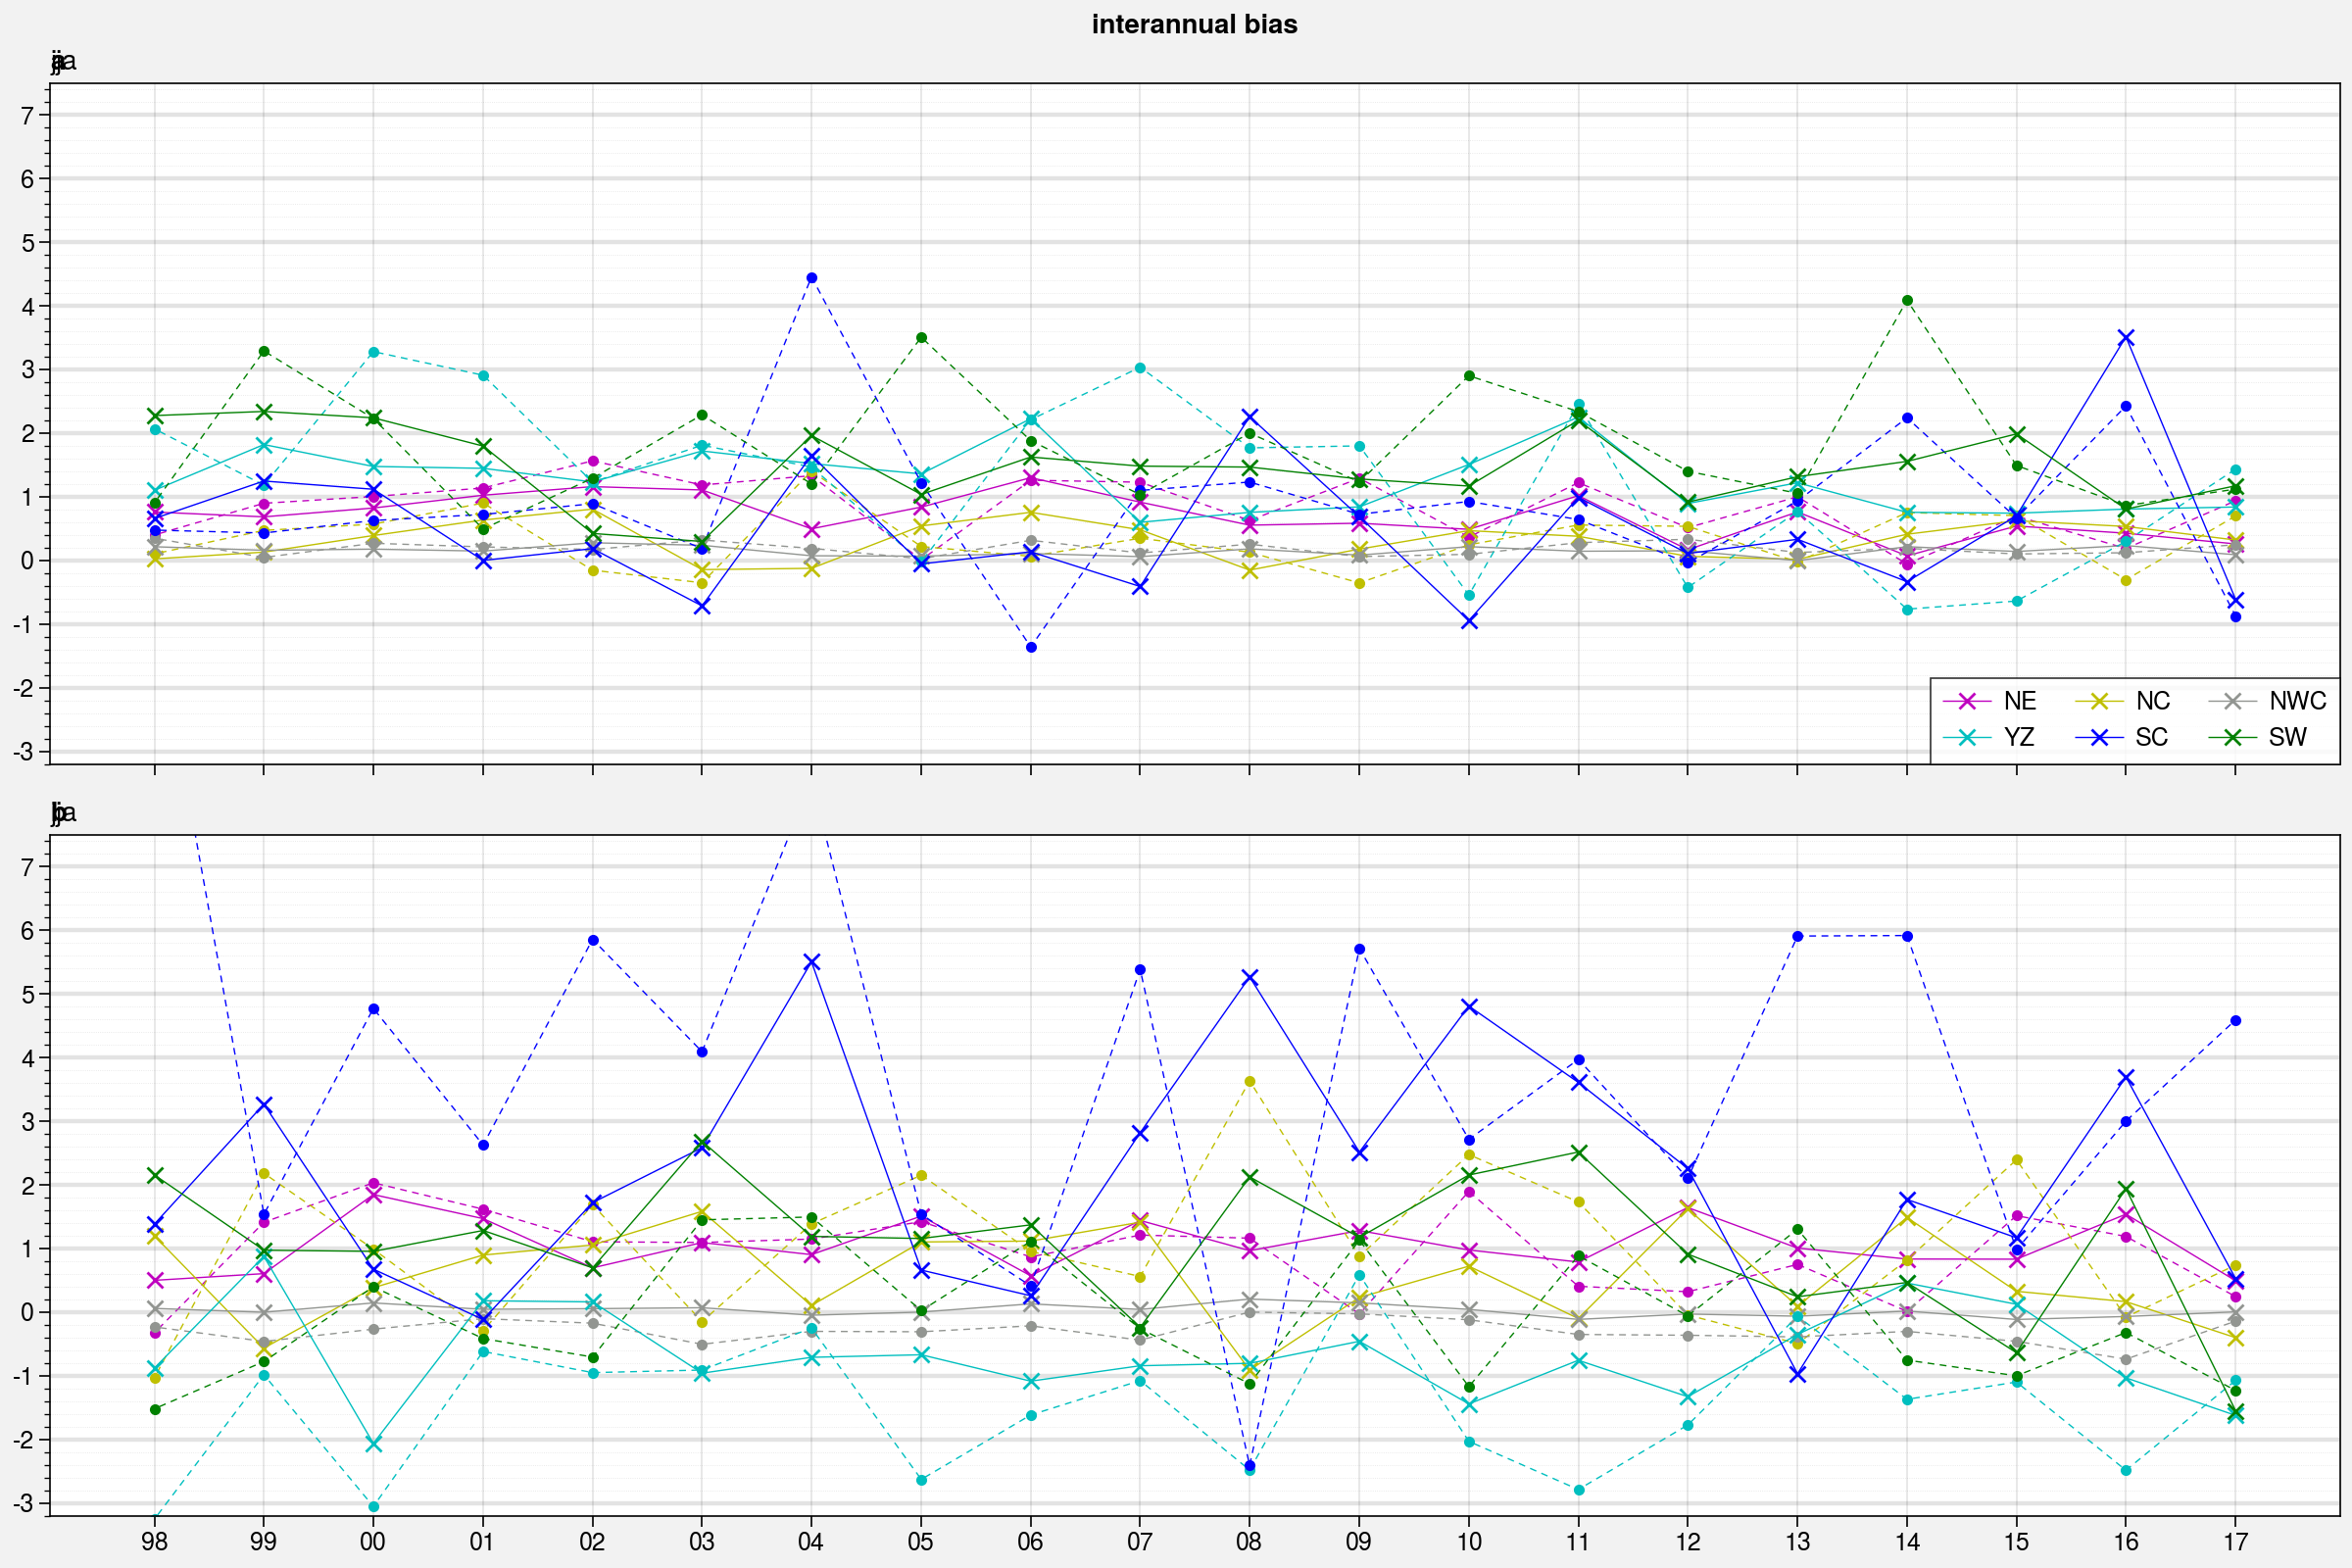

In [69]:
import matplotlib.dates as dates
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

# import matplotlib.pyplot as plt
# plt.style.use(['science', 'no-latex', 'cjk-tc-font'])
# plt.style.use(['science', 'no-latex']) # 采用 安装的scinence绘图风格，matplotlib风格拓展
# fig,ax = plt.subplots(2,1,figsize=(12,8))
fig,ax = plot.subplots(ncols = 1,nrows = 2, figsize=(12,8))
# loop region and seasons
partial_list = ["NE", "NC", "NWC", "YZ", "SC", "SW"] # loop region
seasons_list = ['am', 'jja']            # loop season
# iregion_style_color = {"NE":"m", "NC":"y", "YZ":"c", "SC":"b",'SW':"g",'NWC':"tab:gray"}
color_plot = ["m", "y", "gray", "c", "b", "g"]          # loop color
time_idx = pd.date_range(start = "1998-01-01", end = "2017-01-01",freq='AS') # add time coords


for iseason, season in enumerate(seasons_list):
    for iregion, region in enumerate(partial_list):

        plot_xr = bias_dict[season][region]['vr']
        ax[iseason].plot(time_idx, plot_xr, linestyle = (5, (5, 4)) , color =color_plot[iregion], marker = '.'\
            , linewidth = .5)
        plot_xr = bias_dict[season][region]['rcm']
        ax[iseason].plot(time_idx, plot_xr, linestyle = '-', color =color_plot[iregion], marker = 'x', label = region, linewidth = .5)
        # corr
        # ymin = -1.
        # ymax = 1.
        # rmsd
        ymin = -3.2
        ymax = 7.5
        ax[iseason].set_ylim([ymin,ymax])

        # ax[iseason].set_xlim([xmin,xmax])
        # ax[iseason].xaxis.grid(True, which="minor", linestyle = ":")
        ax[iseason].xaxis.grid(True, which="major", linestyle = "-")
        ax[iseason].yaxis.grid(True, which="minor", linestyle = ":")
        ax[iseason].yaxis.grid(True, which="major", linestyle = "-", linewidth = 1.6)

        ax[iseason].yaxis.set_major_locator(MultipleLocator(1.))
        ax[iseason].yaxis.set_minor_locator(MultipleLocator(.2))
        ax[iseason].yaxis.set_major_formatter(FormatStrFormatter('%1.f'))

        # ax[iseason].set_ylabel()
        # ax[iseason].get_legend().remove()
        ax[iseason].xaxis.set_minor_locator(dates.YearLocator())
        ax[iseason].xaxis.set_minor_formatter(dates.DateFormatter('%y'))
        ax[iseason].xaxis.set_major_locator(dates.YearLocator())
        ax[iseason].xaxis.set_major_formatter(dates.DateFormatter('%y'))
        
        # ax[iseason].set_title(season)
        ax.format(title = season)
    
ax[0].legend(loc = 'lower right')
ax.format(
    abc=True,
    xrotation=0  # rotated time ticks
)
plt.suptitle("interannual bias")
plt.savefig("./output_pic/bias_interannual_6regions.png", dpi = 300, facecolor = "white")

# 用proplot修改绘图风格，绘制bar plot
# ----- 施工中 -----

In [5]:
corr_dict['jja']['YZ']

{'vr': <xarray.DataArray (Time: 20)>
 array([-0.27958622, -0.50827566,  0.14231586, -0.27134622,  0.69382274,
        -0.56579033,  0.40505802, -0.17360584, -0.22635754,  0.23935962,
        -0.63664818,  0.44536806, -0.04067291,  0.61509885,  0.77265925,
         0.3302738 ,  0.68001542, -0.34006119,  0.76370383,  0.01575913])
 Coordinates:
   * Time     (Time) datetime64[ns] 1998-07-16T12:00:00 ... 2017-07-16T12:00:00
     lev      float64 1.0,
 'rcm': <xarray.DataArray (Time: 20)>
 array([ 0.07765189,  0.84653581, -0.23688746, -0.01646017,  0.55857444,
         0.63227453,  0.03782638, -0.57530396,  0.5168729 , -0.02826814,
         0.39648699, -0.08523215,  0.21610664, -0.13821086,  0.78525319,
        -0.02112287,  0.03953028,  0.46570782, -0.52426981,  0.05339154])
 Coordinates:
   * Time     (Time) datetime64[ns] 1998-07-16T12:00:00 ... 2017-07-16T12:00:00
     lev      float64 1.0}

In [6]:
from matplotlib.dates import date2num
# date2num(time_idx)
delta_time = date2num(time_idx)[1] - date2num(time_idx)[0]
delta_time
delta = 0.2 * delta_time
delta

73.0

In [13]:
# time_idx
# bias_dict[season][region]['vr']

DatetimeIndex(['1998-01-01', '1999-01-01', '2000-01-01', '2001-01-01',
               '2002-01-01', '2003-01-01', '2004-01-01', '2005-01-01',
               '2006-01-01', '2007-01-01', '2008-01-01', '2009-01-01',
               '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01',
               '2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01'],
              dtype='datetime64[ns]', freq='AS-JAN')

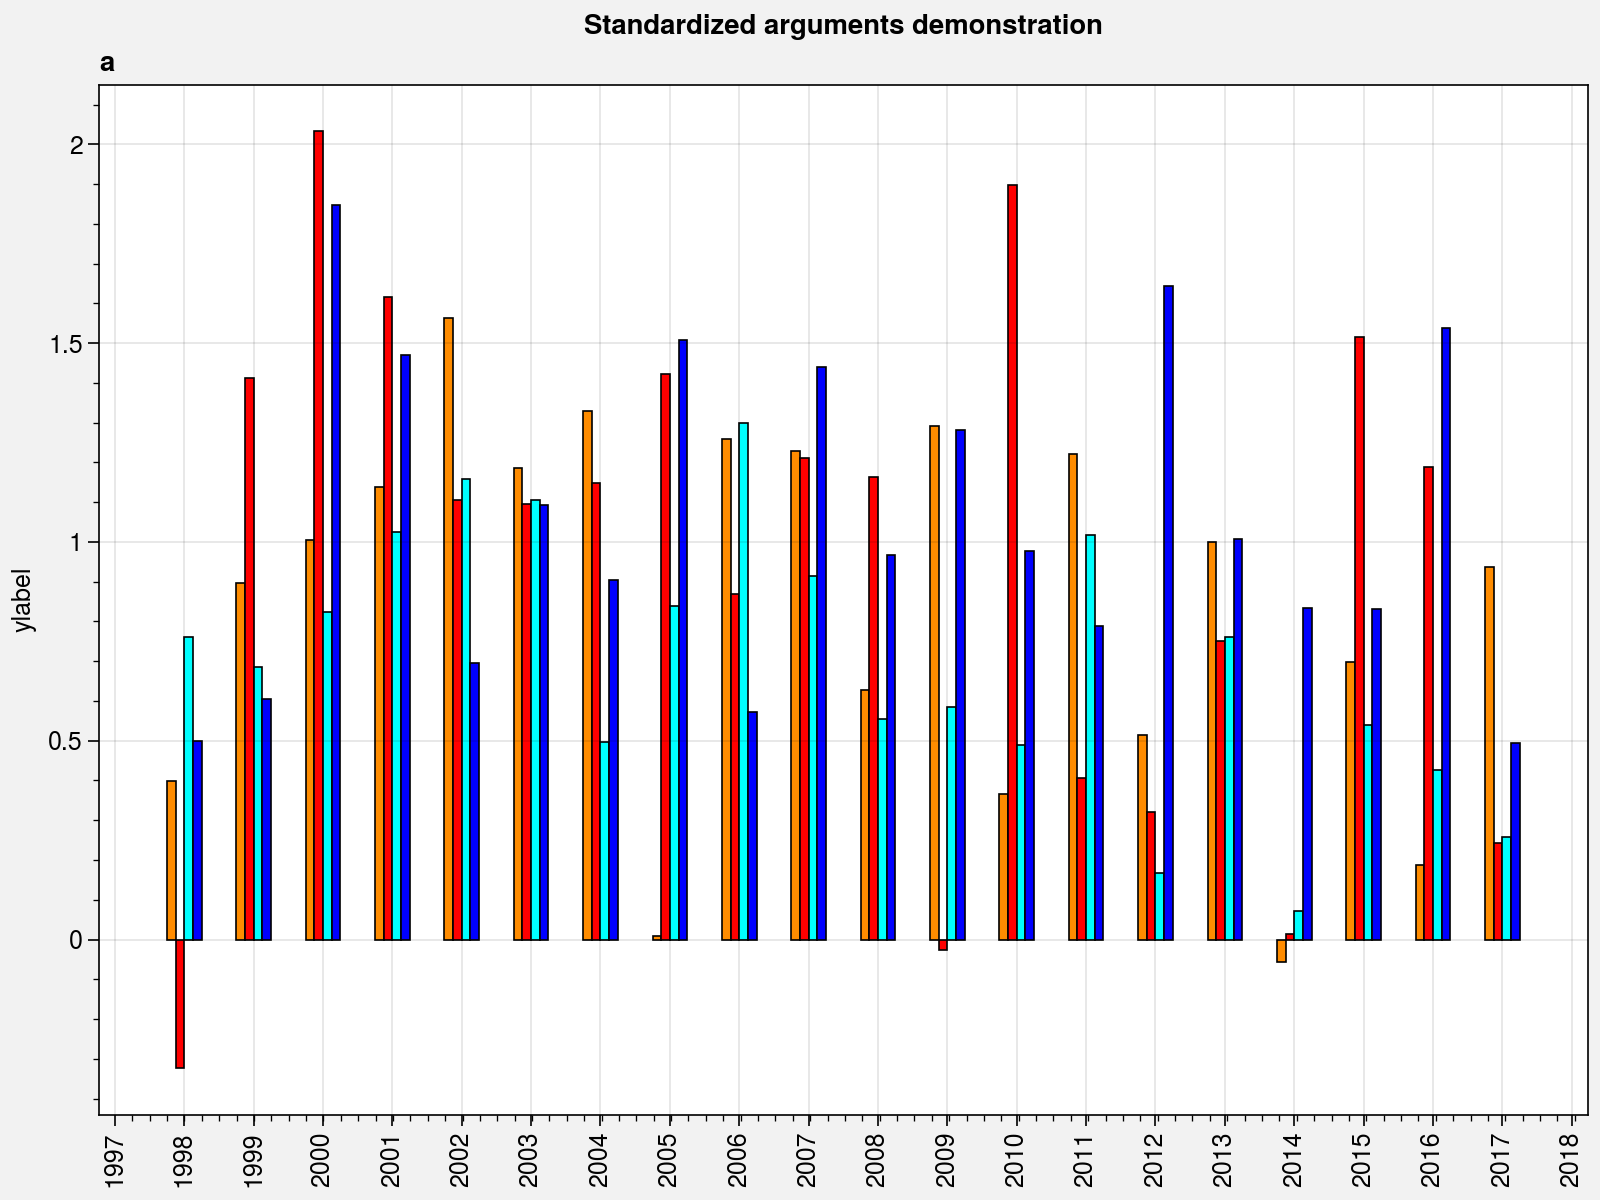

In [81]:
import matplotlib.dates as dates
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

# import matplotlib.pyplot as plt
# plt.style.use(['science', 'no-latex', 'cjk-tc-font'])

# loop region and seasons
partial_list = ["NE", "NC", "NWC", "YZ", "SC", "SW"] # loop region
seasons_list = ['am', 'jja']            # loop season
# color_plot = ["m","y","c","g"]          # loop color
color_plot = ["m", "y", "gray", "c", "b", "g"]          # loop color
time_idx = pd.date_range(start = "1998-01-01", end = "2017-01-01",freq='AS') # add time coords
# time_idx = np.arange(1998,2018,1)

fig, axs = plot.subplots(ncols=1, nrows = 1, figsize=(8,6))
axs.format(xlabel='xlabel', ylabel='ylabel')
axs.format(suptitle='Standardized arguments demonstration')
axs[0].bar( plot_df, cycle = ["darkorange", "red",'cyan', "blue"], width = .5)
# axs[0].plot( plot_df, cycle = ['r', 'b','g','k'])

axs.format(
      xlocator='year',
      xformatter='%Y',
    #   xminorlocator = (),
            # xlocator=np.arange(1998,2018,1),
            
)


In [45]:
plot_df = pd.DataFrame(index = time_idx)
plot_df ['vr-am'] = bias_dict['am']['NE']['vr'].values
plot_df['vr-jja'] = bias_dict['jja']['NE']['vr'].values
plot_df ['rcm-am'] = bias_dict['am']['NE']['rcm'].values
plot_df['rcm-jja'] = bias_dict['jja']['NE']['rcm'].values
plot_df

,vr-am,vr-jja,rcm-am,rcm-jja
1998-01-01,0.399900,-0.323258,0.759958,0.500226
1999-01-01,0.897729,1.411891,0.684345,0.605416
2000-01-01,1.003797,2.032692,0.823477,1.847467
2001-01-01,1.137672,1.617492,1.024176,1.469418
2002-01-01,1.564387,1.105959,1.159137,0.696103
2003-01-01,1.185146,1.094447,1.106777,1.093589
2004-01-01,1.330678,1.148301,0.497016,0.904057
2005-01-01,0.009019,1.421538,0.838034,1.509144
2006-01-01,1.259109,0.868289,1.299613,0.571544
2007-01-01,1.228861,1.211605,0.915537,1.440501
